In [1]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler

# read datasets
train_df = pd.read_csv('data/train2.csv')
test_df = pd.read_csv('data/test2.csv')

y1_name, y2_name, y3_name = "dir_costs", "traffic_costs_s_r", "lost_trips_costs_s_r"
train_y1, train_y2, train_y3 = train_df[y1_name], train_df[y2_name], train_df[y3_name]
test_y1, test_y2, test_y3 = test_df[y1_name], test_df[y2_name], test_df[y3_name]

# scale features
X_train = train_df.drop(columns=[y1_name, y2_name, y3_name])
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = test_df.drop(columns=[y1_name, y2_name, y3_name])
X_test = scaler.transform(X_test)


<h2> Figure out optimal number of clusters </h2>


<h2> Elbow method </h2>

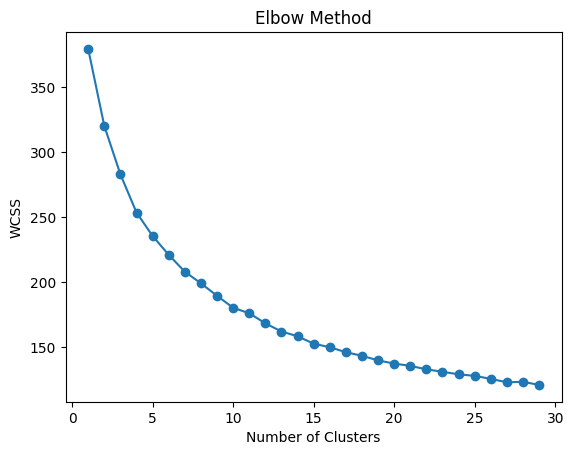

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
cluster_range = range(1, 30)
wcss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [2]:
from sklearn.cluster import KMeans

clusters_num = 4
kmeans = KMeans(n_clusters=clusters_num, random_state=42, n_init=10)
kmeans.fit(X_train)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [3]:
import numpy as np
# transforms X into clustered dataset with. k - number of clusters in the range [0, k-1]
def transform_to_clustered_dataset(X: np.ndarray, cluster_predictor, k: int):
    clusters = cluster_predictor.predict(X)
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res

In [4]:
X_train_clustered = transform_to_clustered_dataset(X_train, kmeans, clusters_num)
X_test_clustered = transform_to_clustered_dataset(X_test, kmeans, clusters_num)

<h1> GBR with arbitrary hyperparameters </h1>

In [5]:
from metrics import print_metrics
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_clustered, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, gb_regressor.predict(X_test_clustered))

print("------ train metrics ------")
print_metrics(train_y3, gb_regressor.predict(X_train_clustered))

------ test metrics ------
Mean Squared Error (MSE):              786486779502931.8750000000
Root Mean Squared Error (RMSE):        28044371.6189707480
Mean Absolute Error (MAE):             14532235.0527576413
R-squared (R²):                        0.6879598345
Mean Absolute Percentage Error (MAPE): 0.1518554637
Max Error (ME):                        230249165.1644266248
Median Absolute Error (MedAE):         5960388.9501196146
------ train metrics ------
Mean Squared Error (MSE):              271421463067814.5000000000
Root Mean Squared Error (RMSE):        16474873.6889790595
Mean Absolute Error (MAE):             9833697.1238999143
R-squared (R²):                        0.8993216558
Mean Absolute Percentage Error (MAPE): 0.1177585550
Max Error (ME):                        112625487.0683588088
Median Absolute Error (MedAE):         5577094.9222848881


<h1> Optimize Gradient boost parameters using Differential evolution</h1>

In [6]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

# define objective function
def objective_function(params, train_X, train_y, test_X, test_y):
    regressor = GradientBoostingRegressor(n_estimators=int(params[0]), learning_rate=params[1], max_depth=int(params[2]), random_state=42)
    regressor.fit(train_X, train_y)
    pred_y = regressor.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

In [7]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(2, 300), (0.0001, 0.5), (2, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.00001,
                                          atol=0.00001,
                                          maxiter=60,
                                          args=(X_train_clustered, train_y3, X_test_clustered, test_y3))
print(optimization_res)

differential_evolution step 1: f(x)= -0.685604
differential_evolution step 2: f(x)= -0.698017
differential_evolution step 3: f(x)= -0.70293
differential_evolution step 4: f(x)= -0.70293
differential_evolution step 5: f(x)= -0.70293
differential_evolution step 6: f(x)= -0.70293
differential_evolution step 7: f(x)= -0.70306
differential_evolution step 8: f(x)= -0.70306
differential_evolution step 9: f(x)= -0.70306
differential_evolution step 10: f(x)= -0.70306
differential_evolution step 11: f(x)= -0.70306
differential_evolution step 12: f(x)= -0.710306
differential_evolution step 13: f(x)= -0.710306
differential_evolution step 14: f(x)= -0.710306
differential_evolution step 15: f(x)= -0.710306
differential_evolution step 16: f(x)= -0.710306
differential_evolution step 17: f(x)= -0.710306
differential_evolution step 18: f(x)= -0.710306
differential_evolution step 19: f(x)= -0.710306
differential_evolution step 20: f(x)= -0.710306
differential_evolution step 21: f(x)= -0.710306
differenti

In [8]:
optimization_res.x

array([1.74573428e+02, 1.51888700e-01, 2.79251442e+00])

In [9]:
from metrics import print_metrics
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=int(optimization_res.x[0]), learning_rate=optimization_res.x[1], max_depth=int(optimization_res.x[2]), random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_clustered, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, gb_regressor.predict(X_test_clustered))

print("------ train metrics ------")
print_metrics(train_y3, gb_regressor.predict(X_train_clustered))

------ test metrics ------
Mean Squared Error (MSE):              714046817624024.1250000000
Root Mean Squared Error (RMSE):        26721654.4701862372
Mean Absolute Error (MAE):             14477531.2558780108
R-squared (R²):                        0.7167005308
Mean Absolute Percentage Error (MAPE): 0.1699060290
Max Error (ME):                        235903475.3310697973
Median Absolute Error (MedAE):         8075610.5907016695
------ train metrics ------
Mean Squared Error (MSE):              303703215187378.3125000000
Root Mean Squared Error (RMSE):        17427082.8077271245
Mean Absolute Error (MAE):             10843233.5405764822
R-squared (R²):                        0.8873473878
Mean Absolute Percentage Error (MAPE): 0.1361571977
Max Error (ME):                        130494726.2480802834
Median Absolute Error (MedAE):         6811947.8928628489
